<h2>Import libraries</h2>

In [1]:
import string
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tomdewildt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/tomdewildt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/tomdewildt/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
lemmatizer = WordNetLemmatizer()

<h2>Read data & EDA</h2>

In [4]:
df = pd.read_csv("../data/tweets.csv", delimiter=",")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
print("The shape of the data is: ", df.shape)

The shape of the data is:  (14640, 15)


Text(0.5, 1.0, 'Count of Sentiments')

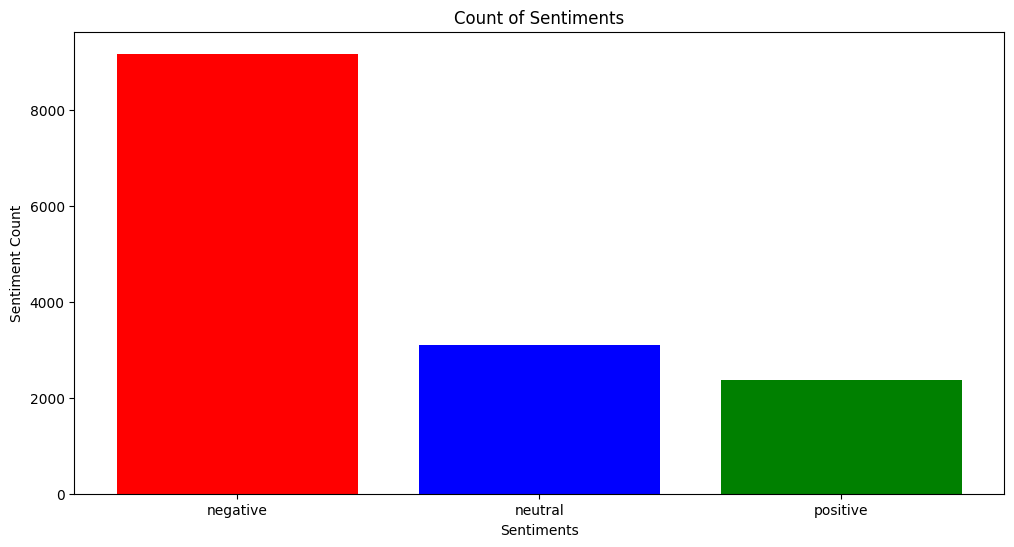

In [6]:
counter = df["airline_sentiment"].value_counts()
index = [1, 2, 3]

plt.figure(1, figsize=(12, 6))
plt.bar(index, counter,color=["red", "blue", "green"])
plt.xticks(index,["negative", "neutral", "positive"], rotation=0)
plt.xlabel("Sentiments")
plt.ylabel("Sentiment Count")
plt.title("Count of Sentiments")

<AxesSubplot:xlabel='airline'>

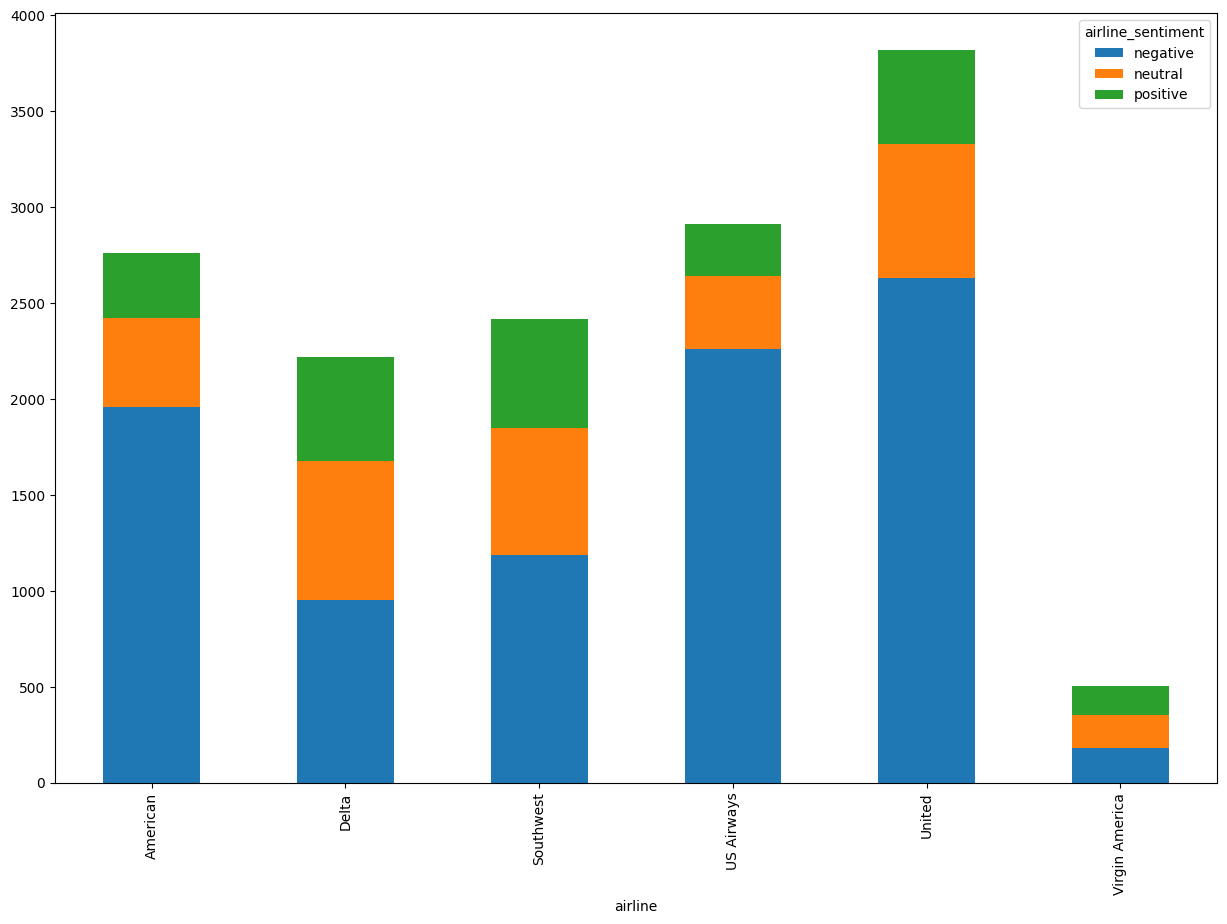

In [7]:
figure_2 = df.groupby(["airline", "airline_sentiment"]).size()
figure_2.unstack().plot(kind="bar", stacked=True, figsize=(15,10))

In [8]:
# Remove Virgin America
df = df[df["airline"] != "Virgin America"]

In [9]:
# Remove ambiguous sentiments
df = df[df["airline_sentiment_confidence"] >= 0.5]
df = df.reset_index(drop=True)
print("The shape of the data is: ", df.shape)

The shape of the data is:  (13910, 15)


In [10]:
# Create variables for prediction
X = df["text"]
Y = df["airline_sentiment"]

<h2>Text preprocessing/cleaning</h2>

In [11]:
stop_words = stopwords.words("english")

for airline in df["airline"].unique():
  stop_words.append(airline.lower())

stop_words.append("us")
stop_words.append("airways")

In [12]:
def preprocess_texts(texts, airline_df, stopwords):
    punctuations = string.punctuation

    clean_data = []
    clean_data_tokenized = []
    for i in range(len(texts)): 
        # Filter any character not in the specified set i.e. keep only letters
        text = re.sub("[^a-zA-Z]", " ", texts.iloc[i])

        # Make a list of words for each text and make it lower case
        text = text.lower().split()

        # Remove the stop words, leftover punctuations and lemmatize the words
        text = [lemmatizer.lemmatize(word) for word in text if (word not in stopwords) and (word not in punctuations)]

        clean_data_tokenized.append(text)

        # Transform the list again to a string
        text = " ".join(text)

        clean_data.append(text)

    return clean_data, clean_data_tokenized

In [13]:
clean_text, clean_text_tokenized = preprocess_texts(X, df, stop_words)

In [14]:
clean_text[1:7]

['thanks taking care mr happy customer',
 'still refund word via dm please resolve issue cancelled flightled flight useless assistant trip',
 'delayed due lack crew delayed long line deicing still need improve service',
 'even international flight glasgow u orlando newark min',
 'think boarded flight au early think',
 'understand tough way get airport w serious risk accident steep price']

In [15]:
Y

0        positive
1        positive
2        negative
3        negative
4         neutral
           ...   
13905    negative
13906    negative
13907     neutral
13908    negative
13909     neutral
Name: airline_sentiment, Length: 13910, dtype: object

In [16]:
Y.unique()

array(['positive', 'negative', 'neutral'], dtype=object)

In [17]:
# Encode labels
le = preprocessing.LabelEncoder()

le.fit(Y.unique())

y_encoded = list(le.transform(Y))

In [18]:
# Create bag of words considering every word occurence
count_vectorizer = CountVectorizer(ngram_range=(1, 1), stop_words=stop_words)

X_feat = count_vectorizer.fit_transform(clean_text).toarray()

In [19]:
X_feat.shape

(13910, 12066)

In [20]:
# Create a model instance and split dataset to train and test sets
model = MultinomialNB()

X_train, X_test, Y_train, Y_test = train_test_split(X_feat,Y, test_size=0.3)

In [21]:
# Fit the model using training set
model.fit(X_train, Y_train)

MultinomialNB()

In [22]:
y_pred = model.predict(X_test)

In [23]:
classification = classification_report(Y_test, y_pred, output_dict=True)

print(classification["accuracy"])

0.7618020608674815


<h2>Tune CountVectorizer</h2>

In [24]:
dd = np.sum(X_feat,axis=0)
vocab = count_vectorizer.get_feature_names_out()

list_of_word_occurences = []
for tag, count in zip(vocab, dd):
    list_of_word_occurences.append((tag, count))

word_count_df = pd.DataFrame(list_of_word_occurences, columns=["Tag", "Count"])

In [25]:
word_count_df = word_count_df.sort_values(by=["Count"], ascending=False)

In [26]:
word_count_df

,Tag,Count
3758,flight,4426
11094,usairways,3016
364,americanair,2935
9682,southwestair,2406
5428,jetblue,2340
...,...,...
5514,joni,1
5511,jokesonus,1
5510,jokerunning,1
294,alicia,1


In [27]:
word_count_df["Count"].mean()

11.150256920271838

In [28]:
word_count_df["Count"].std()

78.90372284629974

In [29]:
word_count_df["Count"].describe()

count    12066.000000
mean        11.150257
std         78.903723
min          1.000000
25%          1.000000
50%          1.000000
75%          4.000000
max       4426.000000
Name: Count, dtype: float64

<h2>Tune CountVectorizer with absolute number of features and ngrams</h2>

In [30]:
def ngrams_features(clean_texts):
    ngrams = [(1, 1), (1, 2), (1, 3), (2, 2), (3, 3)]
    features_list = [5000, 4000, 3000, 2000, 1000]

    test_df = pd.DataFrame(columns=["ngram", "feature_num", "accuracy"])

    for ngram in ngrams:
        for feat in features_list:
            count_vectorizer = CountVectorizer(analyzer="word", ngram_range=ngram, max_features=feat, stop_words=stop_words)
            X_feat = count_vectorizer.fit_transform(clean_texts).toarray()

            # Create a model instance and split dataset to train and test sets
            model = MultinomialNB()
            X_train, X_test, Y_train, Y_test = train_test_split(X_feat, Y, test_size=0.3)

            # Fit the model using training set
            model.fit(X_train, Y_train)

            y_pred = model.predict(X_test)

            classification = classification_report(Y_test, y_pred, output_dict=True)

            res_dict = {"ngram": ngram, "feature_num": feat, "accuracy": classification["accuracy"]}
            res_df = pd.DataFrame([res_dict])

            test_df = pd.concat([test_df, res_df], ignore_index=True, axis=0)

    return test_df

In [31]:
ngrams_features(clean_text).sort_values(by=["accuracy"], ascending=False)

,ngram,feature_num,accuracy
0,"(1, 1)",5000,0.780973
7,"(1, 2)",3000,0.778097
13,"(1, 3)",2000,0.776420
10,"(1, 3)",5000,0.775701
8,"(1, 2)",2000,0.774023
5,"(1, 2)",5000,0.773784
3,"(1, 1)",2000,0.772586
1,"(1, 1)",4000,0.769470
11,"(1, 3)",4000,0.766355
2,"(1, 1)",3000,0.766355


<h2>Tune CountVectorizer with max/min document frequency and ngrams</h2>

In [32]:
def ngrams_maxdocfreq(clean_texts):
    ngrams = [(1, 1), (1, 2), (1, 3), (2, 2), (3, 3)]
    termfreqlist = [2, 3]

    test_df = pd.DataFrame(columns=["ngram", "term_frequency", "accuracy"])

    for ngram in ngrams:
        for termfreq in termfreqlist:
            count_vectorizer = CountVectorizer(analyzer="word", ngram_range=ngram, min_df=termfreq, stop_words=stop_words)
            X_feat = count_vectorizer.fit_transform(clean_texts).toarray()

            # Create a model instance and split dataset to train and test sets
            model = MultinomialNB()
            X_train, X_test, Y_train, Y_test = train_test_split(X_feat, Y, test_size=0.3)

            # Fit the model using training set
            model.fit(X_train, Y_train)

            y_pred = model.predict(X_test)

            classification = classification_report(Y_test, y_pred, output_dict=True)

            res_dict = {"ngram": ngram, "term_frequency": termfreq, "accuracy": classification["accuracy"]}
            res_df = pd.DataFrame([res_dict])

            test_df = pd.concat([test_df, res_df], ignore_index=True, axis=0)

    return test_df

In [33]:
ngrams_maxdocfreq(clean_text).sort_values(by=["accuracy"], ascending=False)

,ngram,term_frequency,accuracy
4,"(1, 3)",2,0.783369
3,"(1, 2)",3,0.782890
2,"(1, 2)",2,0.780014
5,"(1, 3)",3,0.777618
1,"(1, 1)",3,0.774263
0,"(1, 1)",2,0.773065
6,"(2, 2)",2,0.704289
7,"(2, 2)",3,0.702372
8,"(3, 3)",2,0.668344
9,"(3, 3)",3,0.667865


<h2>Tuning model performance expanding the stop words</h2>

In [34]:
from copy import deepcopy


df2 = deepcopy(word_count_df)

In [35]:
df2 = df2[df2["Count"] < 10]

len(df2["Tag"].unique())

10459

In [36]:
df2["Count"].sum()

20189

In [37]:
df2.groupby(["Count"]).count()

,Tag
Count,
1,6812
2,1479
3,731
4,457
5,310
6,219
7,197
8,131
9,123


In [38]:
df2 = df2[df2["Count"] == 1]

len(df2["Tag"].unique())

6812

In [39]:
len(stop_words)

186

In [40]:
for word in df2["Tag"]:
    stop_words.append(word)

In [41]:
len(stop_words)

6998

In [42]:
count_vectorizer = CountVectorizer(analyzer="word", stop_words=stop_words)
X_feat = count_vectorizer.fit_transform(clean_text).toarray()

print(X_feat.shape)

# Create a model instance and split dataset to train and test sets
model = MultinomialNB()
X_train, X_test, Y_train, Y_test = train_test_split(X_feat, Y, test_size=0.3)

# Fit the model using training set
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

classification = classification_report(Y_test, y_pred, output_dict=True)

(13910, 5254)


In [43]:
classification["accuracy"]

0.7687514977234603